# An example of how simple it is to use emcee

Arthur Loureiro - UCL PAD Feb/2019

> *Extremely* based on emcee's example found [here](https://emcee.readthedocs.io/en/latest/tutorials/line/)

In [22]:
%matplotlib inline
import emcee
import matplotlib.pyplot as plt
import numpy as np
import pylab as plt
import matplotlib as mpl

mpl.rcParams.update({'font.size': 20})
np.random.seed(2112)

## Creating some data:

In this emcee example, we'll probe a linear model with 3 different parameters. First we need to create a fake dataset with $y(x) = a_{true}x + b_{true}$ and an aditional fractional error in the covariance estimates, $f_{true}$.

In [2]:
# Choose the "true" parameters.
a_true = -0.9594
b_true = 4.294
f_true = 0.534


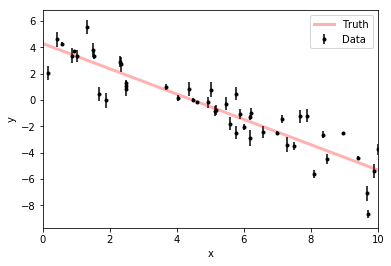

In [3]:
# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = a_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label='Data')
x0 = np.linspace(0, 10, 500)
plt.plot(x0, a_true*x0+b_true, "r", alpha=0.3, lw=3, label='Truth')
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc=0)

# Likelihood:
The log-Likelihood can be defined in this case as:

#### $\ln Pr(y |d,\sigma,a,b,f) = -\frac{1}{2}\sum_i \left[ \frac{(y_i - ax_i -b)^2}{\Sigma_i^2} + \ln(2\pi\Sigma_i^2)\right]$

where, $\Sigma_i^2 \equiv \sigma_i^2 + f^2(ax_i+b)^2$ -- meaning that the variance can be considered to have been underestimated by some fractional amount, $f$.

In [4]:
def log_likelihood(theta, x, y, yerr):
    a, b, log_f = theta
    model = a * x + b
    sigma2 = yerr**2 + model**2*np.exp(2*log_f)
    return -0.5*np.sum((y-model)**2/sigma2 + np.log(sigma2))

#### If we don't feel like being Bayesians, we can try a Maximum Likelihood estimate using `scipy.optimize` to _minimize the log-likelihood_ (or maximize the likelihood)

In [5]:
%%time
from scipy.optimize import minimize
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([a_true, b_true, np.log(f_true)]) + 0.1*np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
a_ml, b_ml, log_f_ml = soln.x

CPU times: user 15.6 ms, sys: 15.6 ms, total: 31.2 ms
Wall time: 9.18 ms


Maximum likelihood estimates:
a = -0.927
b = 4.139
f = 0.434


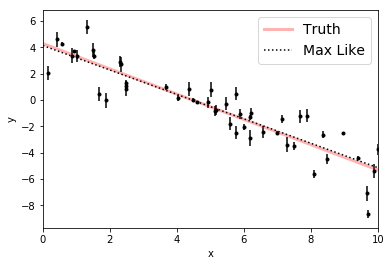

In [6]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, a_true*x0+b_true, "r", alpha=0.3, lw=3, label="Truth")
plt.plot(x0, np.dot(np.vander(x0, 2), [a_ml, b_ml]), ":k", label="Max Like")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

print("Maximum likelihood estimates:")
print("a = {0:.3f}".format(a_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

# Priors:

For simplicity, let us consider flat, uniform priors:

$\Pi(a) = \begin{cases} 1 , & if\, -5 < a < 1/2 \\ 0,& otherwise\end{cases}$

$\Pi(b) = \begin{cases} 1 , & if\, 0 < b < 10 \\ 0,& otherwise\end{cases}$

$\Pi(f) = \begin{cases} 1 , & if\, -10 < \log(f) < 1 \\ 0,& otherwise\end{cases}$

In [7]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

# Posterior:

Finally, we can now write the posterior distribution of the parameters as:
#### $Pr(a,b,f \, | x,y,\sigma) \propto Pr(y |d,\sigma,a,b,f)\Pi(a,b,f)$

In [8]:
def log_posterior(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

### Now we set the sampler to run $N_{samples}=5000$

In [10]:
%%time
pos = soln.x + 1e-4*np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000);

CPU times: user 13.3 s, sys: 125 ms, total: 13.5 s
Wall time: 13.3 s


#### Checking individually the chains:

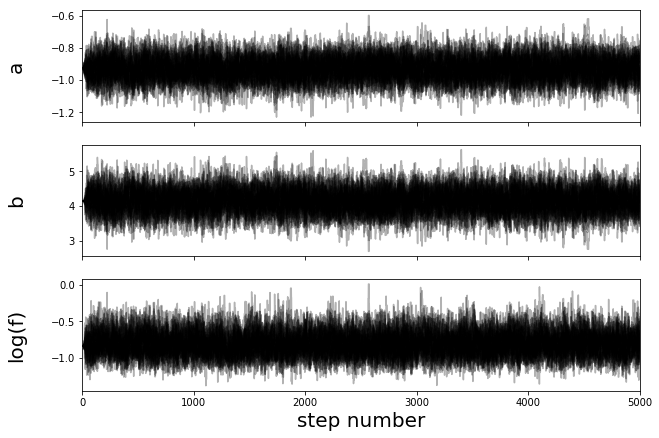

In [15]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],fontdict={'fontsize':20})
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number", fontdict={'fontsize':20});

## Burn-in:

As any MCMC sampler, emcee also needs to "forget" the first points in the chain which are related to finding the peak from the inicial step. Using the `.get_autocorr_time()` method gives an intuition about how many samples to throw away.

In [16]:
T = sampler.get_autocorr_time()
print(T)

[39.07936281 39.41373402 38.54851774]


Throwing away around 100 samples should be fine for the burn-in.

In [17]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

## Results

Now let us marginalise the chain in each of the parameters' dimensions.

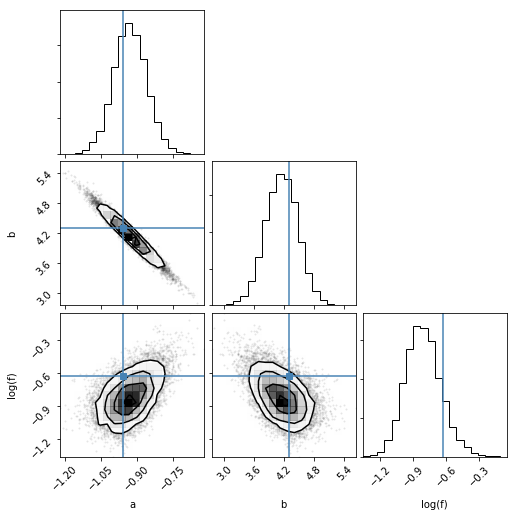

In [19]:
import corner
fig = corner.corner(flat_samples, labels=labels, truths=[a_true, b_true, np.log(f_true)])

### Projecting the samples into data-space:

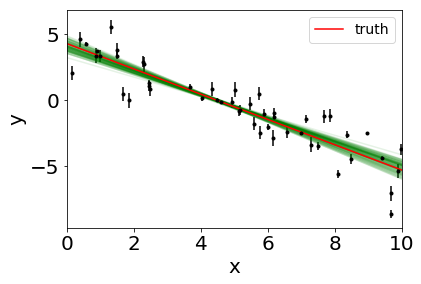

In [23]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "g", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, a_true*x0+b_true, "r", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

### Finally, the 1D marginalized results:

Recall that the true values were:

$a_{true} = -0.9594$

$b_{true} = 4.294$

$\log(f_{true}) = 0.534$

In [24]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>